- Funções utilizadas

In [148]:
scorers = {'recall_score': make_scorer(recall_score)}

def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=15)
    grid_search = GridSearchCV(model, grid_params, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, verbose=1, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of KNN optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

def plot_roc_curve(fpr, tpr, label=None):
    """
    The ROC curve, modified from 
    Hands-On Machine learning with Scikit-Learn and TensorFlow; p.91
    """
    plt.figure(figsize=(8,8))
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.005, 1, 0, 1.005])
    plt.xticks(np.arange(0,1, 0.05), rotation=90)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate (Recall)")
    plt.legend(loc='best')

- Bibliotecas e configurações do pandas e matplotlib

In [141]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import roc_curve, precision_recall_curve, make_scorer, recall_score, confusion_matrix, auc
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.linear_model import LogisticRegression


rcParams['figure.figsize'] = (8, 8)
rcParams['figure.dpi'] = 150

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
df = pd.read_csv('training_data.csv', sep=';')
df.head()

,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition
0,25,Travel_Rarely,685,Research & Development,1,3,Life Sciences,1,350,1,Female,62,3,2,Manufacturing Director,3,Married,4898,7505,0,Y,No,12,3,4,80,2,5,3,3,4,2,1,2,0
1,44,Travel_Rarely,1376,Human Resources,1,2,Medical,1,1098,2,Male,91,2,3,Human Resources,1,Married,10482,2326,9,Y,No,14,3,4,80,1,24,1,3,20,6,3,6,1
2,27,Travel_Rarely,135,Research & Development,17,4,Life Sciences,1,1405,4,Female,51,3,1,Research Scientist,3,Single,2394,25681,1,Y,Yes,13,3,4,80,0,8,2,3,8,2,7,7,1
3,40,Travel_Frequently,580,Sales,5,4,Life Sciences,1,729,4,Male,48,2,3,Sales Executive,1,Married,10475,23772,5,Y,Yes,21,4,3,80,1,20,2,3,18,13,1,12,0
4,24,Travel_Rarely,477,Research & Development,24,3,Medical,1,1173,4,Male,49,3,1,Laboratory Technician,2,Single,3597,6409,8,Y,No,22,4,4,80,0,6,2,3,4,3,1,2,0


In [4]:
df['OverTime'] = df['OverTime'].replace({'Yes':1, 'No':0})

In [5]:
cols = ['OverTime', 'JobLevel', 'MonthlyIncome', 'YearsAtCompany', 'Age', 'Attrition']
df = df[cols]

In [6]:
X = df.drop('Attrition', axis=1)
y = df.Attrition

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=51)

In [8]:
print('Training set shape: ', X_train.shape, y_train.shape)
print('Testing set shape: ', X_test.shape, y_test.shape)

Training set shape:  (882, 5) (882,)
Testing set shape:  (294, 5) (294,)


In [9]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
scaler.fit(X_test)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

- Implementando o modelo KNN

In [86]:
model = KNeighborsClassifier(n_neighbors=5)
model.fit(X_train_scaled, y_train) 

KNeighborsClassifier()

In [87]:
pred_train_knn = model.predict(X_train_scaled)
pred_test_knn = model.predict(X_test_scaled)

In [89]:
cm = confusion_matrix(y_test, pred_test_knn, labels=model.classes_)
disp1 = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)

- Otimizando os hiperparâmetros

In [78]:
grid_params = {
    'n_neighbors' : [2, 3, 4, 5, 6, 10, 15],
    'metric': ['euclidean', 'manhattan'],
    'weights': ['uniform', 'distance'],
}

In [79]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Fitting 15 folds for each of 28 candidates, totalling 420 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 296 tasks      | elapsed:   10.5s


Best params for recall_score
{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

Confusion matrix of KNN optimized for recall_score on the test data:
     pred_neg  pred_pos
neg       232         8
pos        44        10


[Parallel(n_jobs=-1)]: Done 405 out of 420 | elapsed:   12.3s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done 420 out of 420 | elapsed:   12.4s finished


In [81]:
grid_search_clf.best_params_

{'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'uniform'}

- Modelo Refinado

In [90]:
model = KNeighborsClassifier(n_neighbors=3, metric='manhattan', weights='uniform')
model.fit(X_train_scaled, y_train) 

pred_train_knn_refiined = model.predict(X_train_scaled)
pred_test_knn_refined = model.predict(X_test_scaled)

In [91]:
cm2 = confusion_matrix(y_test, pred_test_knn_refined, labels=model.classes_)
disp2 = ConfusionMatrixDisplay(confusion_matrix=cm2, display_labels=model.classes_)

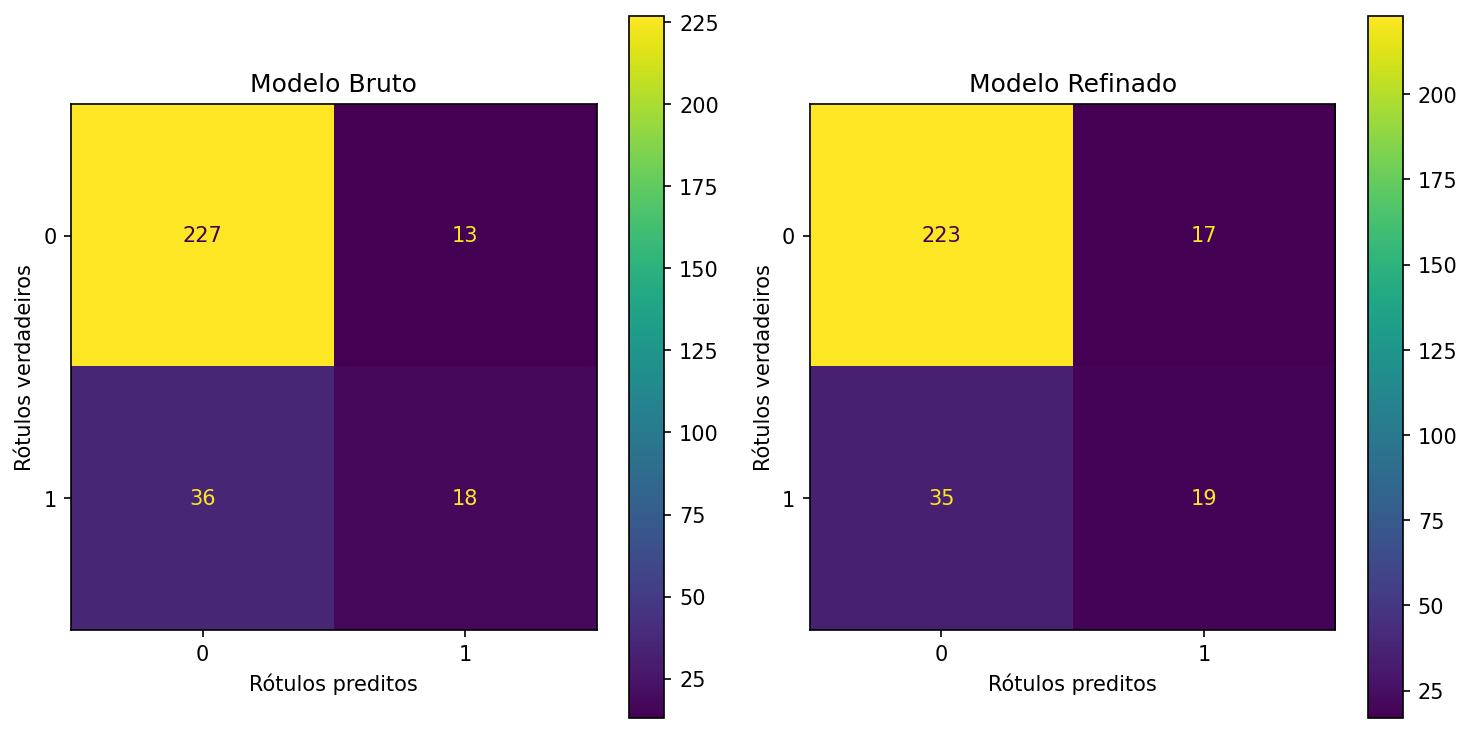

In [92]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

disp1.plot(ax=ax1)
disp2.plot(ax=ax2)

ax1.set_title('Modelo Bruto')
ax1.set_xlabel('Rótulos preditos')
ax1.set_ylabel('Rótulos verdadeiros')

ax2.set_title('Modelo Refinado')
ax2.set_xlabel('Rótulos preditos')
ax2.set_ylabel('Rótulos verdadeiros')

fig.tight_layout()

plt.show()

In [95]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.88      0.97      0.92       746
           1       0.64      0.31      0.42       136

    accuracy                           0.87       882
   macro avg       0.76      0.64      0.67       882
weighted avg       0.85      0.87      0.85       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.95      0.90       240
           1       0.58      0.33      0.42        54

    accuracy                           0.83       294
   macro avg       0.72      0.64      0.66       294
weighted avg       0.81      0.83      0.81       294



In [96]:
print(f'{"Modelo Otimizado":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_knn_refiined)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_knn_refined)}')

----------------------Modelo Otimizado----------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.90      0.97      0.94       746
           1       0.74      0.40      0.52       136

    accuracy                           0.89       882
   macro avg       0.82      0.69      0.73       882
weighted avg       0.88      0.89      0.87       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.86      0.93      0.90       240
           1       0.53      0.35      0.42        54

    accuracy                           0.82       294
   macro avg       0.70      0.64      0.66       294
weighted avg       0.80      0.82      0.81       294



- Ajuste do limite (threshold) para separação de classes

In [103]:
y_score = model.predict_proba(X_test_scaled)[:,1] # predict_proba retorna as probabilidades de cada entrada ser de determinada classe

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

In [117]:
p, r, thresholds = precision_recall_curve(y_test, y_score) # obtenção dos parâmetros de precisão, recall e limiares

- Fonte: https://towardsdatascience.com/predict-vs-predict-proba-scikit-learn-bdc45daa5972

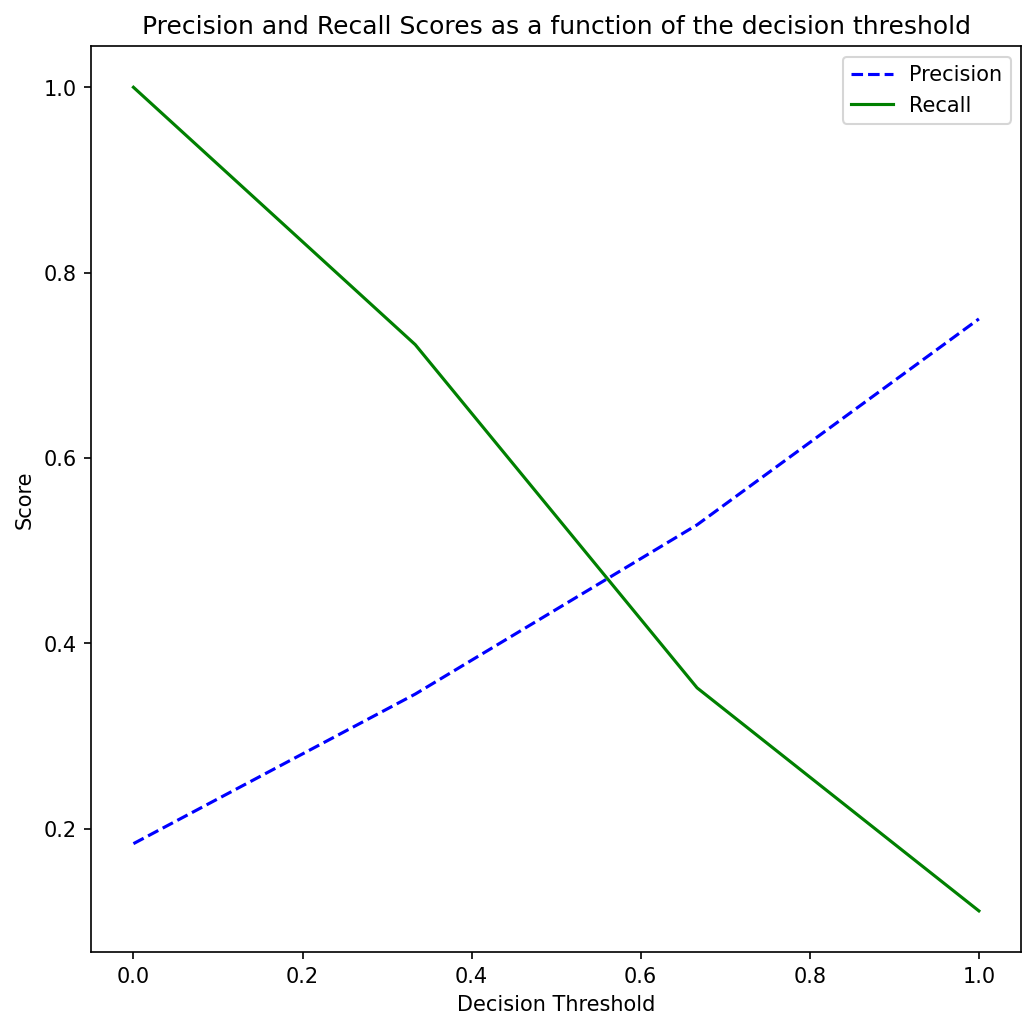

In [115]:
plot_precision_recall_vs_threshold(p, r, thresholds) # Relação da precisão e do recall para diferentes limiares de separação. 

- Fonte: https://www.ibm.com/docs/en/contentclassificatio/8.8?topic=analysis-category-graph-precision-recall-vs-threshold

- Cálculo da área abaixo da curva ROC. Quanto mais próximo de 1 melhor.

0.7380787037037038


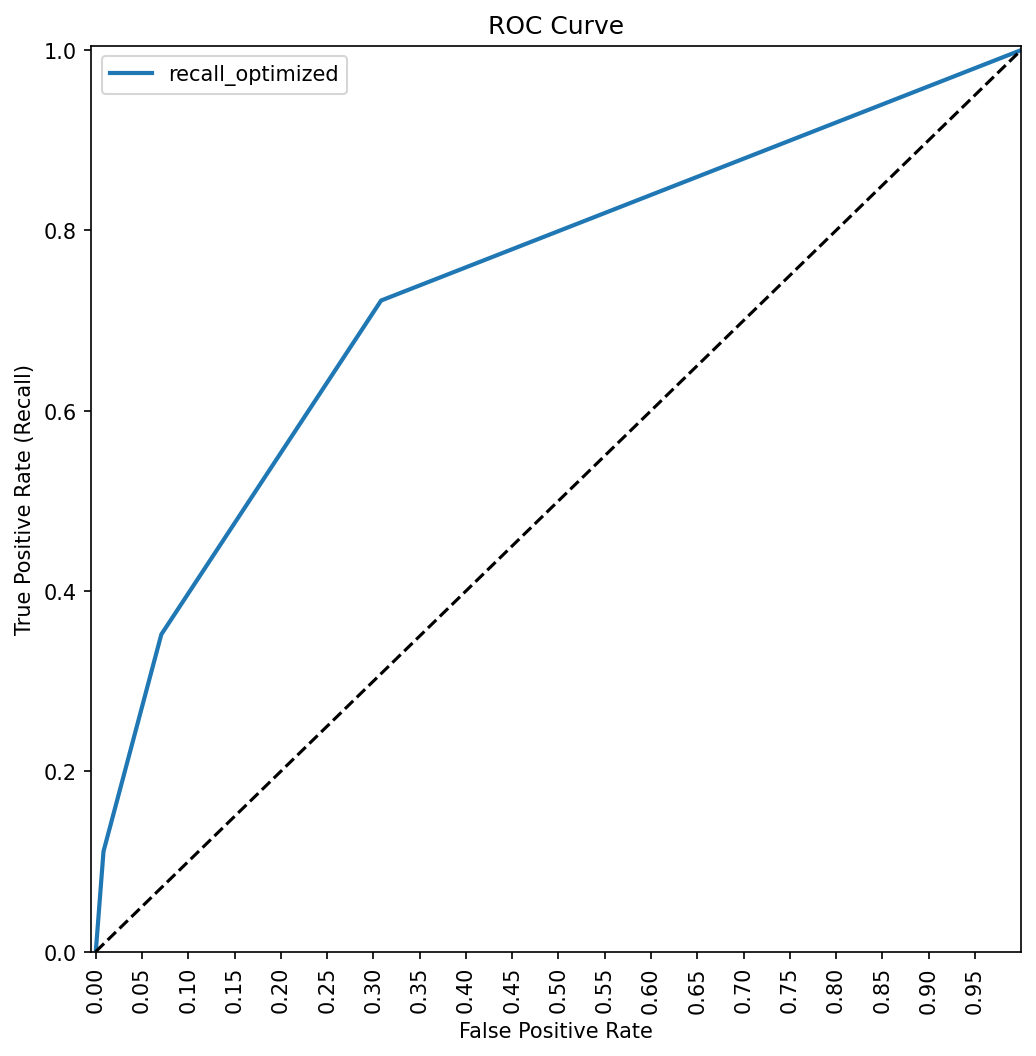

In [116]:
fpr, tpr, auc_thresholds = roc_curve(y_test, y_score)
print(auc(fpr, tpr)) # AUC of ROC
plot_roc_curve(fpr, tpr, 'recall_optimized')

- Ideal seria a curva em azul

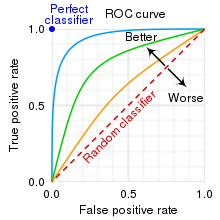

### Random Forest (Em construção)

In [149]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier()

forest.fit(X_train_scaled, y_train)

pred_train_rf = forest.predict(X_train_scaled)
pred_test_rf = forest.predict(X_test_scaled)

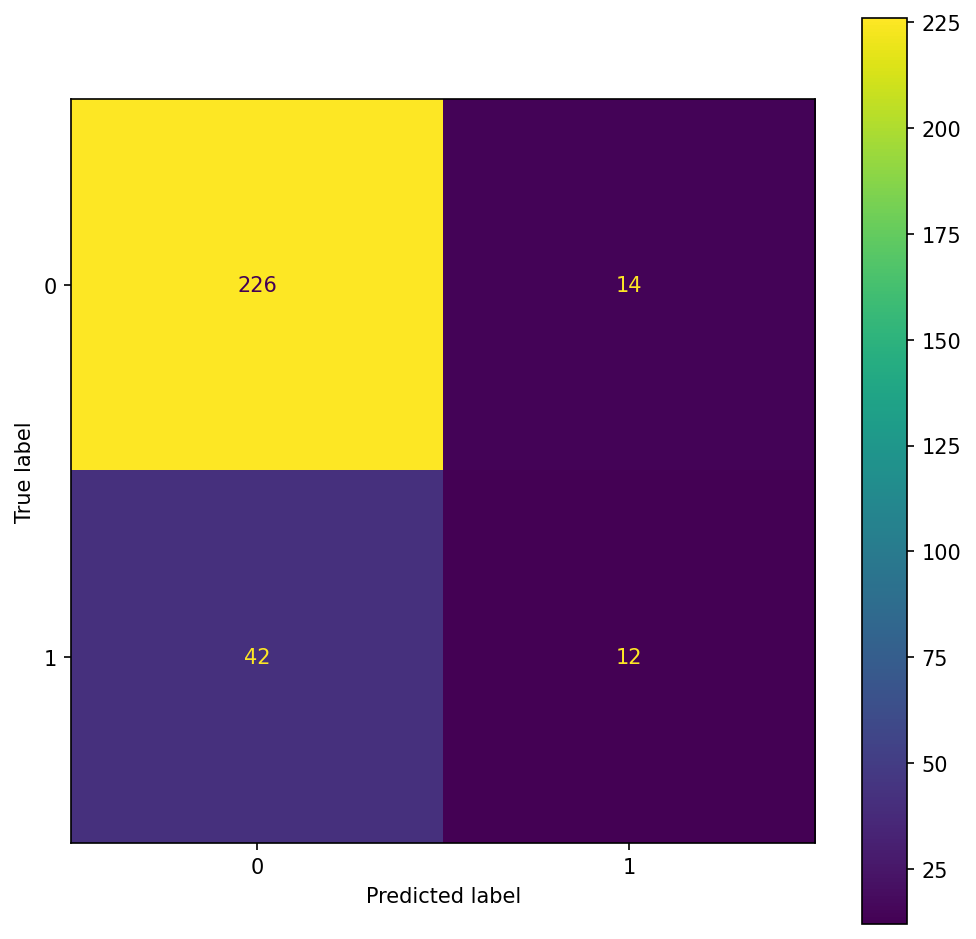

In [150]:
cm = confusion_matrix(y_test, pred_test_rf, labels=forest.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=forest.classes_)
disp.plot()

In [151]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_rf)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_rf)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       746
           1       1.00      1.00      1.00       136

    accuracy                           1.00       882
   macro avg       1.00      1.00      1.00       882
weighted avg       1.00      1.00      1.00       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.84      0.94      0.89       240
           1       0.46      0.22      0.30        54

    accuracy                           0.81       294
   macro avg       0.65      0.58      0.59       294
weighted avg       0.77      0.81      0.78       294



- Logistic Regression (Em construção)

In [152]:
log = LogisticRegression()
log.fit(X_train_scaled, y_train)

pred_train_log = log.predict(X_train_scaled)
pred_test_log = log.predict(X_test_scaled)

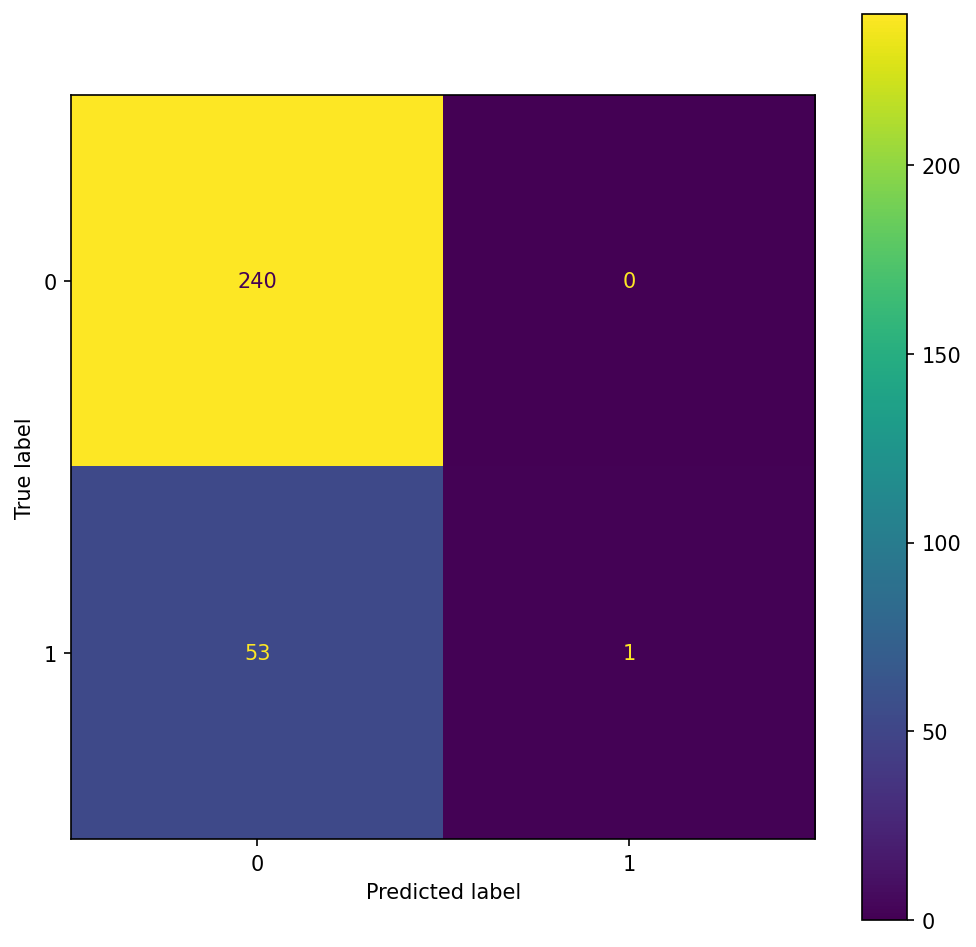

In [153]:
cm = confusion_matrix(y_test, pred_test_log, labels=log.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=log.classes_)
disp.plot()

In [154]:
print(f'{"Modelo Bruto":-^60}\n')
print(f'{"Train":-^60}\n{classification_report(y_train, pred_train_log)}', end='\n\n')
print(f'{"Test":-^60}\n{classification_report(y_test, pred_test_log)}')

------------------------Modelo Bruto------------------------

---------------------------Train----------------------------
              precision    recall  f1-score   support

           0       0.85      1.00      0.92       746
           1       0.00      0.00      0.00       136

    accuracy                           0.85       882
   macro avg       0.42      0.50      0.46       882
weighted avg       0.72      0.85      0.78       882


----------------------------Test----------------------------
              precision    recall  f1-score   support

           0       0.82      1.00      0.90       240
           1       1.00      0.02      0.04        54

    accuracy                           0.82       294
   macro avg       0.91      0.51      0.47       294
weighted avg       0.85      0.82      0.74       294



c:\Users\felip\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
